Number of rows are in the data set 1932760
Fraction of calls in this data set deal with traffic 0.024412239491711334
Median of this average annual number of calls per police district 12185.5
Pearson correlation coefficient of the number of calls received for each ZIP code with the ZIP code population 0.8643031213852042


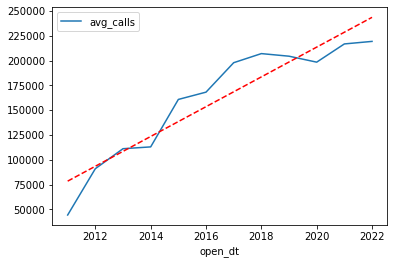

Estimated increase year on year using a line of best fit. 15012.81818181756
Average days after garbage collection are requests for street cleaning made 3.287351443123939


In [2]:
# Using Pandas for the calculation
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import time


# To Supress warnings
import warnings
warnings.filterwarnings("ignore")



# Loading Data into DataFrames
df = pd.read_csv("./boston_311_calls.csv")
df_pop = pd.read_csv("./boston_population_by_zip.csv")
df_garbage_collection = pd.read_csv("./boston_02128_garbage_schedule.csv")

# Converting to date time, as it will be usfull to extract year, month day etc
df.open_dt = pd.to_datetime(df.open_dt)
df.closed_dt = pd.to_datetime(df.closed_dt)

#### 1. Row count of a Pandas DataFrame, there are many other cammands. shape[0] row count, shape[1] column count
row_count = df.shape[0]

print(f"Number of rows are in the data set {row_count}")

#### 2. Fraction of calls in this data set deal with traffic?
# When filtering it is always better to use no case sensitive
traffic_calls = df['case_title'].str.contains("traffic", case=False, na=False).sum()/df.shape[0]


print(f"Fraction of calls in this data set deal with traffic {traffic_calls}")


#### 3. Median of this average annual number of calls per police district

df_calls = df.groupby([df.police_district.str.replace("-",""),df.open_dt.dt.year]).size().reset_index(name='avg_calls')



median_calls = df_calls['avg_calls'].median()


print(f"Median of this average annual number of calls per police district {median_calls}")


#### 4. Pearson correlation coefficient of the number of calls received for each ZIP code with the ZIP code population 
# regular expression pattern to match zip codes
pattern = r'(\b\d{5}(?:-\d{4})?\b)'



# use str.extract() to extract zip codes from 'Address' column
df['Zip_Code'] = df['location'].str.extract(pattern).fillna(0).astype(int)

# Create DF - received calls in a given ZIP 
df_zip_calls = df.groupby(['Zip_Code']).size().reset_index(name='avg_calls')


# Exclude data less than or equal to 100
df_zip_calls = df_zip_calls[df_zip_calls['avg_calls'] >100]


# Merge Data Frames of zipcode and Data Frame of population
df_zip_calls = df_zip_calls.merge(df_pop, on='Zip_Code',how='left')



# Calculate correlation
corr = df_zip_calls['Population'].corr(df_zip_calls['avg_calls'], method='pearson')

print(f"Pearson correlation coefficient of the number of calls received for each ZIP code with the ZIP code population {corr}")


#### 5. Visualize this trend by plotting the annual number of calls as a function of time
# Create Data Frames year vs calls
df_year_calls = df.groupby([df.open_dt.dt.year]).size().reset_index(name='avg_calls')
df_year_calls.plot(x='open_dt',y='avg_calls')



# adding trend line
x = df_year_calls['open_dt']
y = df_year_calls['avg_calls']
coefficients= pd.np.polyfit(x, y, 1)
p = pd.np.poly1d(coefficients)
plt.plot(x, p(x), 'r--')



# show the plot
plt.show()

print(f"Estimated increase year on year using a line of best fit. {coefficients[0]}")


#### 6. Average days after garbage collection are requests for street cleaning made

df_garbage = df[(df['Zip_Code']==2128) & (df['type']=="Requests for Street Cleaning")].reset_index(drop=True)



# compute pairwise distances between rows of the two DataFrames
distances = cdist( df_garbage[['latitude','longitude']], df_garbage_collection[['latitude','longitude']],metric='euclidean')


# find the index of the row in df2 that is closest to each row in df1
closest_indices = pd.np.argmin(distances, axis=1)



# df_garbage['cleaning_requestday'] = df_garbage['open_dt'].dt.day_name()
# add the corresponding row from df2 to each row in df1
df_garbage['trashday'] = df_garbage_collection.iloc[closest_indices]['trashday'].values



# Convert Weekday name to numeric
df_garbage["request_date_in_num"] = df_garbage['open_dt'].dt.weekday
df_garbage["collection_date_in_num"] = df_garbage['trashday'].apply(lambda x: time.strptime(x, "%A").tm_wday)

# Calculate average collection days
df_garbage['days_after_garbage_collection'] = df_garbage["collection_date_in_num"] - df_garbage["request_date_in_num"]
df_garbage['days_after_garbage_collection'][df_garbage["request_date_in_num"]>df_garbage["collection_date_in_num"]] = 7 - df_garbage["request_date_in_num"]+df_garbage["collection_date_in_num"]



average_collection_days = df_garbage['days_after_garbage_collection'].mean()



print(f"Average days after garbage collection are requests for street cleaning made {average_collection_days}")


